# Evaluation and submission analysis for DeepRacer

This notebook has been built based on the `DeepRacer Log Analysis.ipynb` provided by the AWS DeepRacer Team. It has been reorganised and expanded to provide new views on the evaluation/racing data in a cleaner way, without the helper code which was moved into utility `.py` files.

**You will find this notebook most useful for race submissions reviews and because of that it is mostly focusing on this goal.**

## Usage

I am assuming here that you have already become familiar with `Training_analysis.ipynb`. Therefore descriptions that you will find here may be missing some bits if already described in there.

Since this file can change in the future, I recommend that you make its copy and reorganize it to your liking. This way you will not lose your changes and you'll be able to add things as you please.

**This notebook isn't complete.** What I find interesting in the logs may not be what you will find interesting and useful. I recommend you get familiar with the tools and try hacking around to get the insights that suit your needs.

## Contributions

As usual, your ideas are very welcome and encouraged so if you have any suggestions either bring them to [the AWS DeepRacer Community](http://join.deepracing.io) or share as code contributions.

## Training environments

Depending on whether you're running your evaluations through the console or using the local setup, and on which setup for local training you're using, your experience will vary. As much as I would like everything to be taylored to your configuration, there may be some problems that you may face. If so, please get in touch through [the AWS DeepRacer Community](http://join.deepracing.io).

For race submissions it is much more straightforward.

## Requirements

Before you start using the notebook, you will need to install some dependencies. If you haven't yet done so, have a look at [The README.md file](/edit/README.md#running-the-notebooks) to find what you need to install.

Apart from the install, you also have to configure your programmatic access to AWS. Have a look at the guides below, AWS resources will lead you by the hand:

AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html

Boto Configuration: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

## Credits

I would like to thank [the AWS DeepRacer Community](http://join.deepracing.io) for all the feedback about the notebooks. If you'd like, follow [my blog](https://codelikeamother.uk) where I tend to write about my experiences with AWS DeepRacer.

# Log Analysis

Let's get to it.

## Imports

Run the imports block below:

In [1]:

from deepracer.tracks import TrackIO, Track

from deepracer.logs import CloudWatchLogs as cw, \
    AnalysisUtils as au, \
    SimulationLogsIO as slio, \
    EvaluationUtils as eu, \
    PlottingUtils as pu

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

## Load waypoints for the track you want to run analysis on

You will notice files for racing tracks. They are community best-effort versions made to make the visualisation in the logs less confusing. They may be slightly differing from reality, we don't know for sure. We do not have access to actual npy files that AWS use in the league.

Tracks Available:

In [2]:
!ls tracks/

tu = TrackIO()

AmericasGeneratedInclStart.npy	New_York_Eval_Track.npy
AWS_track.npy			New_York_Track.npy
Bowtie_track.npy		Oval_track.npy
Canada_Eval.npy			reInvent2019_track.npy
Canada_Training.npy		reInvent2019_wide_mirrored.npy
China_eval_track.npy		reInvent2019_wide.npy
China_track.npy			reinvent_base.npy
FS_June2020.npy			Spain_track.npy
H_track.npy			Straight_track.npy
LGSWide.npy			Tokyo_Training_track.npy
London_Loop_Train.npy		Vegas_track.npy
Mexico_track_eval.npy		Virtual_May19_Train_track.npy
Mexico_track.npy


Loaded 71 waypoints


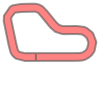

In [3]:
track: Track = tu.load_track("reinvent_base")

track.road_poly

## Load all race submission logs

**WARNING:** If you do not specify `not_older_than` parameter, all evaluation logs will be downloaded. They aren't as big as the training logs, but there is a lot of them.

That said you can download all and then it will only download new ones unless you use force=True.

There are also `not_older_than` and `older_than` parameters so you can choose to fetch all logs from a given period and compare them against each other. Just remember memory is finite.

As mentioned, this method always fetches a list of log streams and then downloads only ones that haven't been downloaded just yet. You can therefore use it to fetch that list and load all the files from the path provided.

Side note: if you want to download evaluation logs from AWS DeepRacer Console, this will be a bit more tricky. Evaluation logs are grouped together with training logs in same group `/aws/robomaker/SimulationJobs` and there isn't an obvious way to recognise which ones they are. That said, in `Evaluation Run Analysis` section below you have the ability to download a single evaluation file.

In [4]:
# For the purpose of generating the notebook in a reproducible way
# logs download has been commented out.
logs = [('logs/training-simulation-logs-y1.log', 'sim-sample')]

# logs = cw.download_all_logs(
#     'logs/deepracer-eval-', 
#     '/aws/deepracer/leaderboard/SimulationJobs', 
#     not_older_than="2019-07-01 07:00", 
#     older_than="2019-07-01 12:00"
# )

In [5]:
# Loads all the logs from the above time range
bulk = slio.load_a_list_of_logs(logs)

## Parse logs and visualize

You will notice in here that reward graps are missing, as are many others from the training. These have been trimmed down for clarity.

Do not get tricked though - this notebook provides features that the training one doesn't have, such as batch visualisation of race submission laps.

Side note: Evaluation/race logs contain a reward field but it's not connected to your reward. It is there most likely to ensure logs have consistent structure to make their parsing easier. The value appears to be dependand on distance of the car from the centre of the track. As such it provides no value and is not visualised in this notebook.

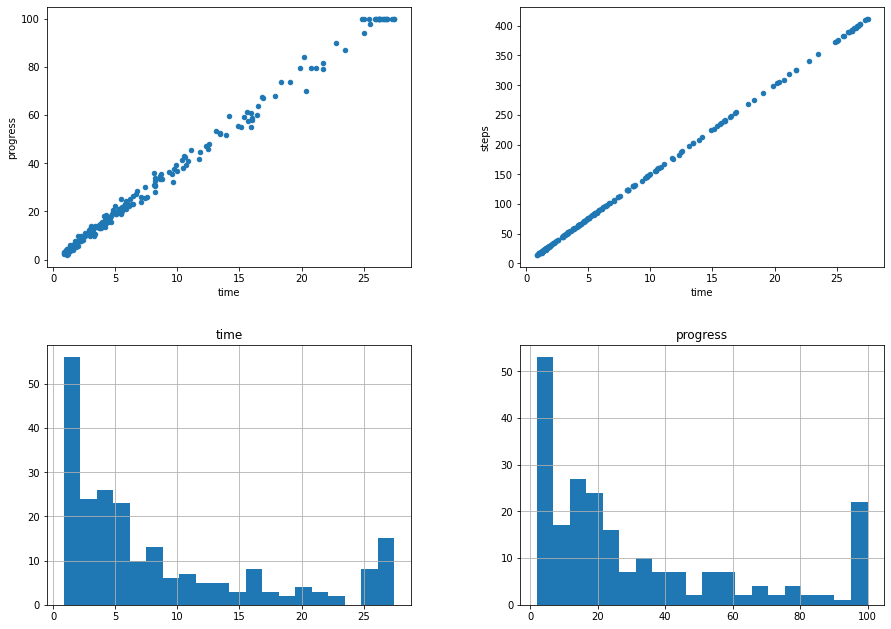

<Figure size 432x288 with 0 Axes>

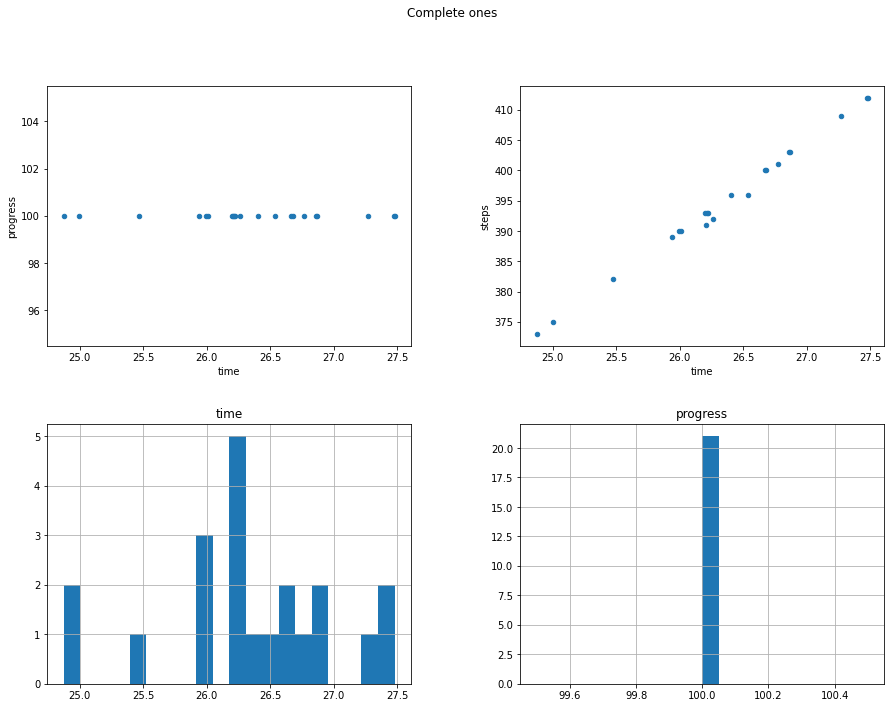

<Figure size 432x288 with 0 Axes>

In [6]:
simulation_agg = au.simulation_agg(bulk, 'stream', add_timestamp=True, is_eval=True)
complete_ones = simulation_agg[simulation_agg['progress']==100]

# This gives the warning about ptp method deprecation. The code looks as if np.ptp was used, I don't know how to fix it.
au.scatter_aggregates(simulation_agg, is_eval=True)
if complete_ones.shape[0] > 0:
    au.scatter_aggregates(complete_ones, "Complete ones", is_eval=True)

## Data in tables

In [7]:
# View fifteen most progressed attempts
simulation_agg.nlargest(15, 'progress')

stream  episode  steps  start_at  progress       time  throttle  \
147  sim-sample      147    393        24     100.0  26.212319  0.613333   
160  sim-sample      160    375         0     100.0  24.999371  0.635547   
182  sim-sample      182    382         6     100.0  25.471411  0.627932   
185  sim-sample      185    392        17     100.0  26.263557  0.612423   
187  sim-sample      187    412        24     100.0  27.476894  0.611481   
190  sim-sample      190    403        35     100.0  26.870741  0.602109   
193  sim-sample      193    393        48     100.0  26.226872  0.602010   
198  sim-sample      198    393        64     100.0  26.202419  0.611450   
199  sim-sample      199    391        68     100.0  26.210038  0.614757   
200  sim-sample      200    390         0     100.0  25.991578  0.624821   
201  sim-sample      201    412         4     100.0  27.479884  0.608811   
202  sim-sample      202    390         6     100.0  26.011362  0.631667   
206  sim-sample      206    389        21     100.0  25.938468  0.640951   
209  sim-sample      209    400        33     100.0  26.682093  0.630825   
210  sim-sample      210    396        35     100.0  26.539865  0.608485   

     time_if_complete                     timestamp  
147         26.212319 2020-06-08 21:24:06.201941729  
160         24.999371 2020-06-08 21:29:43.822577000  
182         25.471411 2020-06-08 21:37:59.713153839  
185         26.263557 2020-06-08 21:38:45.299077272  
187         27.476894 2020-06-08 21:39:26.418516874  
190         26.870741 2020-06-08 21:40:23.987840652  
193         26.226872 2020-06-08 21:41:09.470751286  
198         26.202419 2020-06-08 21:42:39.049031019  
199         26.210038 2020-06-08 21:43:05.861795187  
200         25.991578 2020-06-08 21:48:56.724387407  
201         27.479884 2020-06-08 21:49:24.744046688  
202         26.011362 2020-06-08 21:49:51.286351442  
206         25.938468 2020-06-08 21:50:52.061405420  
209         26.682093 2020-06-08 21:51:27.698957682  
210         26.539865 2020-06-08 21:51:54.839231968

In [8]:
# View fifteen fastest complete laps
complete_ones.nsmallest(15, 'time')

stream  episode  steps  start_at  progress       time  throttle  \
220  sim-sample      220    373         0     100.0  24.875679  0.638257   
160  sim-sample      160    375         0     100.0  24.999371  0.635547   
182  sim-sample      182    382         6     100.0  25.471411  0.627932   
206  sim-sample      206    389        21     100.0  25.938468  0.640951   
200  sim-sample      200    390         0     100.0  25.991578  0.624821   
202  sim-sample      202    390         6     100.0  26.011362  0.631667   
198  sim-sample      198    393        64     100.0  26.202419  0.611450   
199  sim-sample      199    391        68     100.0  26.210038  0.614757   
147  sim-sample      147    393        24     100.0  26.212319  0.613333   
193  sim-sample      193    393        48     100.0  26.226872  0.602010   
185  sim-sample      185    392        17     100.0  26.263557  0.612423   
214  sim-sample      214    396        51     100.0  26.404629  0.609192   
210  sim-sample      210    396        35     100.0  26.539865  0.608485   
216  sim-sample      216    400        55     100.0  26.668188  0.612100   
209  sim-sample      209    400        33     100.0  26.682093  0.630825   

     time_if_complete                     timestamp  
220         24.875679 2020-06-08 21:59:49.602452993  
160         24.999371 2020-06-08 21:29:43.822577000  
182         25.471411 2020-06-08 21:37:59.713153839  
206         25.938468 2020-06-08 21:50:52.061405420  
200         25.991578 2020-06-08 21:48:56.724387407  
202         26.011362 2020-06-08 21:49:51.286351442  
198         26.202419 2020-06-08 21:42:39.049031019  
199         26.210038 2020-06-08 21:43:05.861795187  
147         26.212319 2020-06-08 21:24:06.201941729  
193         26.226872 2020-06-08 21:41:09.470751286  
185         26.263557 2020-06-08 21:38:45.299077272  
214         26.404629 2020-06-08 21:52:51.282353401  
210         26.539865 2020-06-08 21:51:54.839231968  
216         26.668188 2020-06-08 21:53:22.370700836  
209         26.682093 2020-06-08 21:51:27.698957682

In [9]:
# View ten most recent lap attempts
simulation_agg.nlargest(10, 'timestamp')

stream  episode  steps  start_at  progress       time  throttle  \
222  sim-sample      222    309         6   79.4332  20.791269  0.616958   
221  sim-sample      221    403         4  100.0000  26.863843  0.601092   
220  sim-sample      220    373         0  100.0000  24.875679  0.638257   
219  sim-sample      219    401        68  100.0000  26.770534  0.600698   
218  sim-sample      218     24        64    5.6876   1.535480  0.694167   
217  sim-sample      217    409        60  100.0000  27.269476  0.610293   
216  sim-sample      216    400        55  100.0000  26.668188  0.612100   
215  sim-sample      215     51        53   13.0298   3.336316  0.673529   
214  sim-sample      214    396        51  100.0000  26.404629  0.609192   
213  sim-sample      213    124        48   30.5496   8.209951  0.608065   

     time_if_complete                     timestamp  
222         26.174533 2020-06-08 22:00:38.335433722  
221         26.863843 2020-06-08 22:00:17.013086796  
220         24.875679 2020-06-08 21:59:49.602452993  
219         26.770534 2020-06-08 21:54:19.622467756  
218         26.996972 2020-06-08 21:53:52.516862630  
217         27.269476 2020-06-08 21:53:50.177928686  
216         26.668188 2020-06-08 21:53:22.370700836  
215         25.605273 2020-06-08 21:52:55.221547604  
214         26.404629 2020-06-08 21:52:51.282353401  
213         26.874170 2020-06-08 21:52:24.407761097

## Plot all the evaluation laps

The method below plots your evaluation attempts. Just note that that is a time consuming operation and therefore I suggest using `min_distance_to_plot` to just plot some of them.

If you would like to, in a below section of this article you can load a single log file to evaluate this.

In the example below training track data was used for plotting the borders. Since then the community has put a lot of effort into preparing files that resemble the racing ones.

If you want to plot a single lap, scroll down for an example which lets you do a couple more tricks.

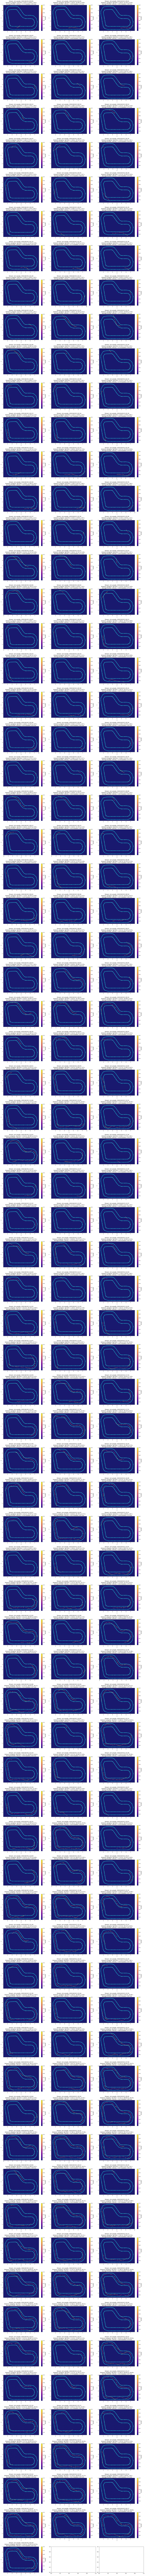

<Figure size 432x288 with 0 Axes>

In [10]:
pu.plot_evaluations(bulk, track)

## Single lap
Below you will find some ideas of looking at a single evaluation lap. You may be interested in a specific part of it. This isn't very robust but can work as a starting point. Please submit your ideas for analysis.

This place is a great chance to learn more about [Pandas](https://pandas.pydata.org/pandas-docs/stable/) and about how to process data series.

In [11]:
# Load a single lap
lap_df = bulk[(bulk['episode']==0) & (bulk['stream']=='sim-sample')]

We're adding a lot of columns here to the episode. To speed things up, it's only done per a single episode, so others will currently be missing this information.

Now try using them as a `graphed_value` parameter.

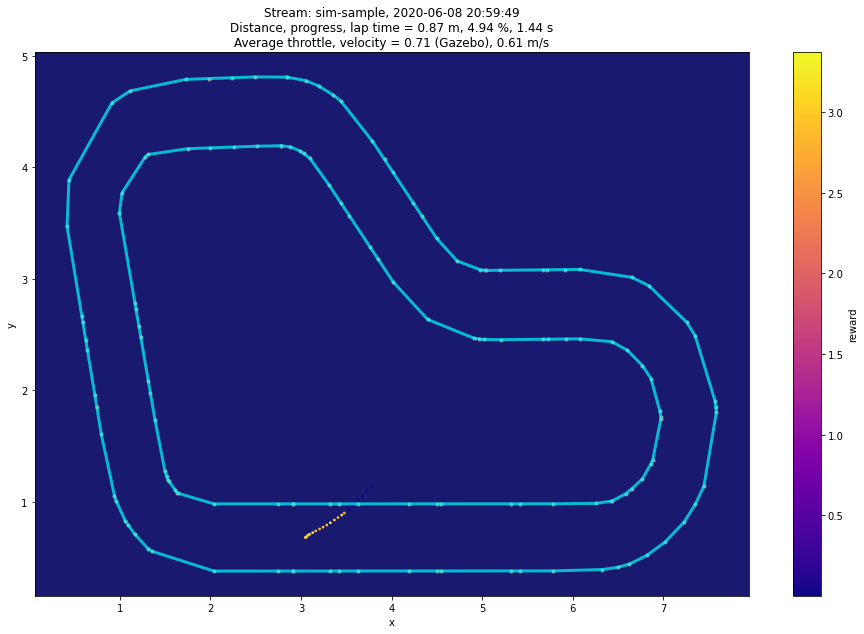

<Figure size 432x288 with 0 Axes>

In [12]:
lap_df.loc[:,'distance']=((lap_df['x'].shift(1)-lap_df['x']) ** 2 + (lap_df['y'].shift(1)-lap_df['y']) ** 2) ** 0.5
lap_df.loc[:,'time']=lap_df['timestamp'].astype(float)-lap_df['timestamp'].shift(1).astype(float)
lap_df.loc[:,'speed']=lap_df['distance']/(100*lap_df['time'])
lap_df.loc[:,'acceleration']=(lap_df['distance']-lap_df['distance'].shift(1))/lap_df['time']
lap_df.loc[:,'progress_delta']=lap_df['progress'].astype(float)-lap_df['progress'].shift(1).astype(float)
lap_df.loc[:,'progress_delta_per_time']=lap_df['progress_delta']/lap_df['time']

pu.plot_grid_world(lap_df, track, graphed_value='reward')

## Evaluation Run Analysis

Debug your evaluation runs or analyze the laps. By providing the evaluation simulation id you can fetch a single log file and use it. You can do the same for race submission but I recommend using the bulk solution above. If you still want to do it, make sure to add `log_group = "/aws/robomaker/leaderboard/SimulationJobs"` to `download_log` call.

In [16]:
# eval_sim = 'sim-sample'
# eval_fname = 'logs/deepracer-eval-%s.log' % eval_sim

eval_fname = 'logs/evaluation-simulation-logs-y1.csv'
# cw.download_log(eval_fname, stream_prefix=eval_sim)

In [17]:
# !head $eval_fname

In [18]:
eval_df = slio.load_pandas(eval_fname)
eval_df.head()

iteration  episode  steps       x       y     yaw  steer  throttle  action  \
0          1        2    399  2.6339  0.8130  8.6039  -30.0      0.33     0.0   
1          1        2    400  2.6692  0.8136  6.9201  -30.0      0.33     0.0   
2          1        2    401  2.6971  0.8127  5.3165    0.0      0.67     4.0   
3          1        2    402  2.7303  0.8104  3.3965  -30.0      0.67     1.0   
4          1        2    403  2.7729  0.8053  0.6813   30.0      0.33     6.0   

   reward  done on_track  progress  closest_waypoint  track_len  \
0     0.5     0     True   98.4379                69      17.67   
1     0.5     0     True   98.6374                69      17.67   
2     0.5     0     True   98.7958                69      17.67   
3     0.5     0     True   98.9832                69      17.67   
4     0.5     0     True   99.2245                69      17.67   

            timestamp  
0  1591654452.1265216  
1  1591654452.1930513  
2   1591654452.262649  
3   1591654452.329692  
4  1591654452.3959208

### Grid World Analysis
The code below visualises laps from a single log file just like the one above visualises it in bulk for many.

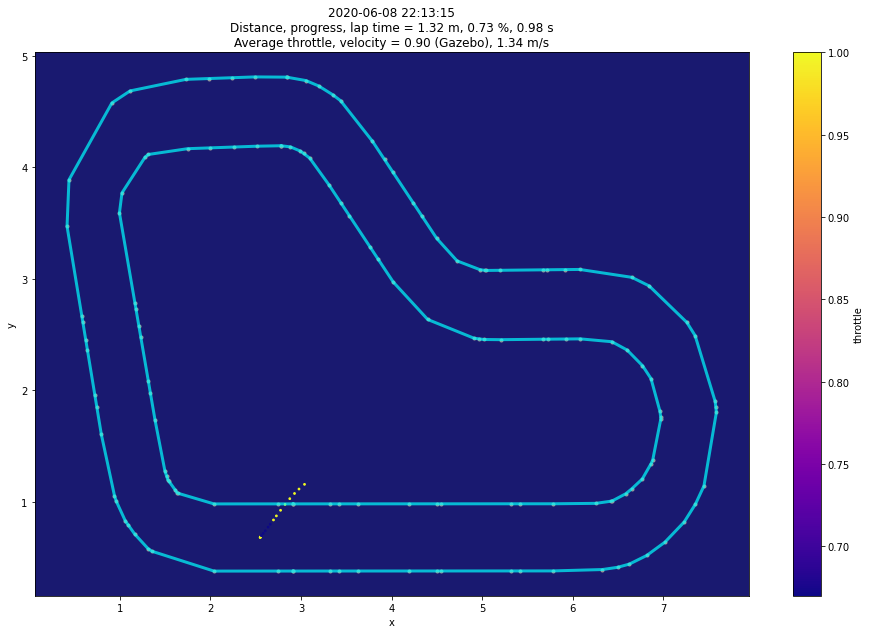

<Figure size 432x288 with 0 Axes>

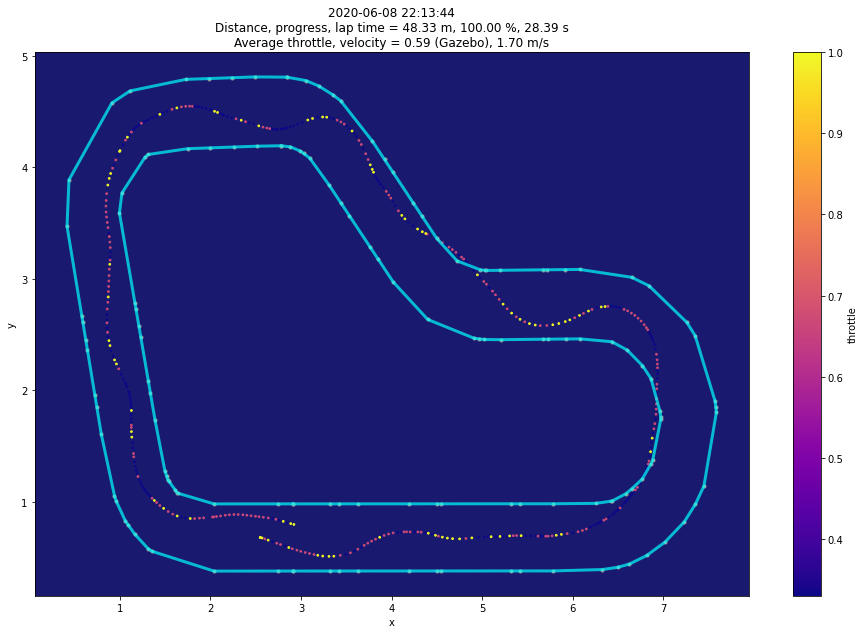

<Figure size 432x288 with 0 Axes>

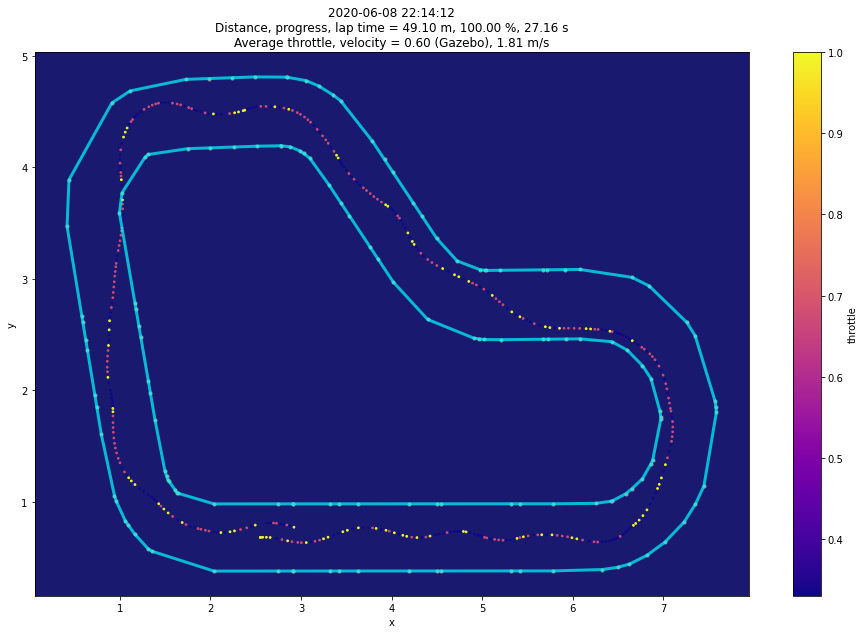

<Figure size 432x288 with 0 Axes>

In [19]:
eu.analyse_single_evaluation(eval_df, track)